In [1]:
import tensorflow as tf
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import glob

In [2]:
train_files = glob.glob('./*/**')

In [3]:
len(train_files)

17760

In [4]:
import random
from random import shuffle
shuffle(train_files)

In [5]:
np.array(Image.open(train_files[0])).shape

(64, 64, 3)

In [6]:
x = np.zeros((10000,224,224,3),dtype='float32')
y = np.zeros((10000,1))
# 0 for Kirmizi , 1 for Siirt

In [7]:
for i in range(10000):
    firstLetter = train_files[i].split('\\')[1][0]
    if(firstLetter=='n'): y[i]=1
    original = Image.open(train_files[i])
    resized = original.resize((224,224),0)
    x[i,:,:,:] = resized

D:\Anaconda\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


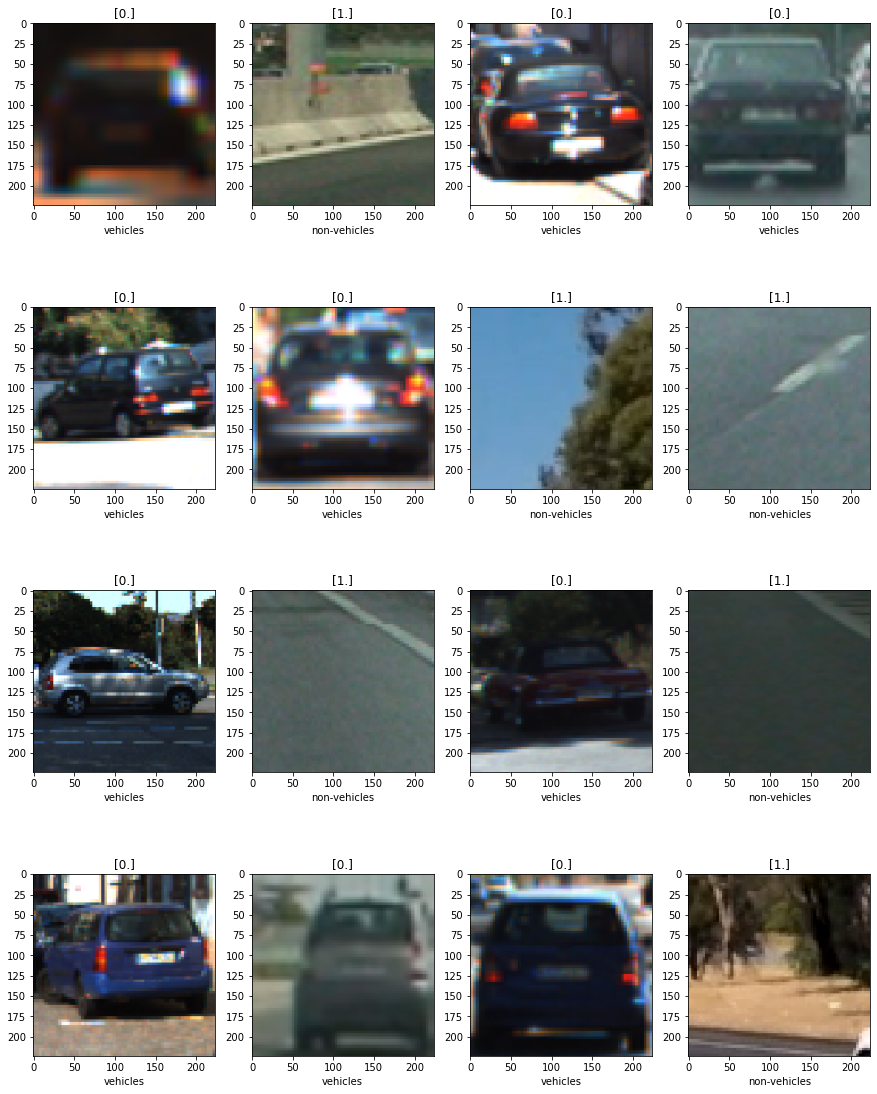

In [8]:
plt.figure(figsize=(15,20))
for i in range(0,16):
    temp = random.randint(0,500)
    plt.subplot(4,4,i+1)
    plt.imshow(x[temp]/255)
    plt.title(y[temp])
    plt.xlabel(train_files[temp].split('\\')[1])

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
x_train,x_test,y_train,y_test = train_test_split(x,y,shuffle=True)


In [11]:
x_train.shape

(7500, 224, 224, 3)

In [12]:
x_train/=255

In [13]:
def Inception_block(input_layer, f_path1, f_path2_conv3x3, f_path2_conv1x1, f_path3_conv1x1, f_path3_conv5x5, f_path4): 

  path1 = tf.keras.layers.Conv2D(filters=f_path1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)

  path2 = tf.keras.layers.Conv2D(filters = f_path2_conv1x1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path2 = tf.keras.layers.Conv2D(filters = f_path2_conv3x3, kernel_size = (3,3), padding = 'same', activation = 'relu')(path2)

  path3 = tf.keras.layers.Conv2D(filters = f_path3_conv1x1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path3 = tf.keras.layers.Conv2D(filters = f_path3_conv5x5, kernel_size = (5,5), padding = 'same', activation = 'relu')(path3)

  path4 = tf.keras.layers.MaxPooling2D((3,3), strides= (1,1), padding = 'same')(input_layer)
  path4 = tf.keras.layers.Conv2D(filters = f_path4, kernel_size = (1,1), padding = 'same', activation = 'relu')(path4)

  output_layer = tf.keras.layers.Concatenate(axis = -1)([path1, path2, path3, path4])

  return output_layer

In [14]:
def GoogLeNet():
  # input layer 
  input_layer = tf.keras.layers.Input(shape = (224, 224, 3))

  # convolutional layer -7x7 + 2S
  X = tf.keras.layers.Conv2D(filters = 64, kernel_size = (7,7), strides = 2, padding = 'valid', activation = 'relu')(input_layer)

  # max-pooling layer - 3x3 +2S
  X = tf.keras.layers.MaxPooling2D(pool_size = (3,3), strides = 2)(X)
  #No LocalRespNorm
  # convolutional layer - 1x1 +1V
  X = tf.keras.layers.Conv2D(filters = 64, kernel_size = (1,1), strides = 1, padding = 'same', activation = 'relu')(X)

  # convolutional layer - 1x1 +1S
  X = tf.keras.layers.Conv2D(filters = 192, kernel_size = (3,3), strides=1,padding = 'same', activation = 'relu')(X)
  #No LocalRespNorm
  # max-pooling layer - 
  X = tf.keras.layers.MaxPooling2D(pool_size= (3,3), strides = 2)(X)

  # Inception block - 3a
  X = Inception_block(X, 64,  96, 128, 16, 32, 32)

  # Inception block - 3b
  X = Inception_block(X, 128, 128, 192, 32, 96, 64)

  # max-pooling layer - 3x3 +2S
  X = tf.keras.layers.MaxPooling2D(pool_size= (3,3), strides = 2)(X)
    
  # Inception block - 4a
  X = Inception_block(X, 192, 96, 208, 16, 48, 64)

  # Extra network - AveragePool -> convolutional layer - 1x1 +1s -> Fully Connected Layer 1024 -> Dropout 0.7 -> Softmax layer
  X1 = tf.keras.layers.AveragePooling2D(pool_size = (5,5), strides = 3)(X)
  X1 = tf.keras.layers.Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X1)
  X1 = tf.keras.layers.Flatten()(X1)
  X1 = tf.keras.layers.Dense(1024, activation = 'relu')(X1)
  X1 = tf.keras.layers.Dropout(0.7)(X1)
  X1 = tf.keras.layers.Dense(2, activation = 'softmax')(X1)

  # Inception block - 4b
  X = Inception_block(X, 160, 112, 224, 24, 64, 64)

  # Inception block - 4c
  X = Inception_block(X, 128, 128, 256, 24, 64, 64)

  # Inception block - 4d
  X = Inception_block(X, 112, 144, 288, 32, 64, 64)

  # Extra network - AveragePool -> convolutional layer - 1x1 +1s -> Fully Connected Layer 1024 -> Dropout 0.7 -> Softmax layer
  X2 = tf.keras.layers.AveragePooling2D(pool_size = (5,5), strides = 3)(X)
  X2 = tf.keras.layers.Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X2)
  X2 = tf.keras.layers.Flatten()(X2)
  X2 = tf.keras.layers.Dense(1024, activation = 'relu')(X2)
  X2 = tf.keras.layers.Dropout(0.7)(X2)
  X2 = tf.keras.layers.Dense(2, activation = 'softmax')(X2)
    
  # Inception block - 4e
  X = Inception_block(X, 256, 160, 320, 32, 128, 128)

  # max-pooling layer - 3x3 + 2S
  X = tf.keras.layers.MaxPooling2D(pool_size = (3,3), strides = 2)(X)

  # Inception block - 5a 
  X = Inception_block(X, 256, 160, 320, 32, 128, 128)

  # Inception block - 5b
  X = Inception_block(X, 384, 192, 384, 48, 128, 128)

  # avg pool - 7x7 + 1(V)
  X = tf.keras.layers.GlobalAveragePooling2D(name='GAPL')(X)

  # Dropoutlayer - 40% 
  X = tf.keras.layers.Dropout(0.4)(X)

  # output layer 
  X = tf.keras.layers.Dense(2, activation = 'softmax')(X)
  
  # model
  model = tf.keras.models.Model(input_layer, [X, X1, X2], name = 'GoogLeNet')

  return model

In [15]:
model = GoogLeNet()

In [16]:
model.summary()

Model: "GoogLeNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 109, 109, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 54, 54, 64)   0           ['conv2d[0][0]']                 
                                                                                          

                                                                                                  
 conv2d_24 (Conv2D)             (None, 12, 12, 112)  225904      ['conv2d_23[0][0]']              
                                                                                                  
 conv2d_26 (Conv2D)             (None, 12, 12, 64)   38464       ['conv2d_25[0][0]']              
                                                                                                  
 conv2d_27 (Conv2D)             (None, 12, 12, 64)   25664       ['max_pooling2d_6[0][0]']        
                                                                                                  
 concatenate_3 (Concatenate)    (None, 12, 12, 400)  0           ['conv2d_22[0][0]',              
                                                                  'conv2d_24[0][0]',              
                                                                  'conv2d_26[0][0]',              
          

 conv2d_51 (Conv2D)             (None, 5, 5, 128)    102528      ['conv2d_50[0][0]']              
                                                                                                  
 conv2d_52 (Conv2D)             (None, 5, 5, 128)    86144       ['max_pooling2d_11[0][0]']       
                                                                                                  
 concatenate_7 (Concatenate)    (None, 5, 5, 672)    0           ['conv2d_47[0][0]',              
                                                                  'conv2d_49[0][0]',              
                                                                  'conv2d_51[0][0]',              
                                                                  'conv2d_52[0][0]']              
                                                                                                  
 conv2d_54 (Conv2D)             (None, 5, 5, 384)    258432      ['concatenate_7[0][0]']          
          

In [17]:
model.compile(loss=['sparse_categorical_crossentropy', 'sparse_categorical_crossentropy', 'sparse_categorical_crossentropy'], metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, [y_train,y_train,y_train],epochs=2)

Epoch 1/2
235/235 [==============================] - 705s 3s/step - loss: 2.1252 - dense_4_loss: 0.8168 - dense_1_loss: 0.5968 - dense_3_loss: 0.7115 - dense_4_accuracy: 0.6827 - dense_1_accuracy: 0.7096 - dense_3_accuracy: 0.6932
Epoch 2/2
 55/235 [======>.......................] - ETA: 8:50 - loss: 4.2791 - dense_4_loss: 2.2317 - dense_1_loss: 0.7003 - dense_3_loss: 1.3470 - dense_4_accuracy: 0.8551 - dense_1_accuracy: 0.8614 - dense_3_accuracy: 0.8551

In [ ]:
model.evaluat